<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/modelos_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparación de Modelos de Regresión – Ames Housing

Este notebook implementa y compara el rendimiento de nueve modelos de regresión utilizando el dataset **Ames Housing**, previamente preprocesado.  
Se emplea validación cruzada de 5 folds y se calculan métricas clave: **MAE**, **MSE**, **R²** y **MAPE**.

El objetivo es identificar los modelos más adecuados para predecir precios de vivienda, optimizando sus hiperparámetros en etapas posteriores.



In [186]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.
dashboard  notebooks	  requirements.txt
data	   parte_teorica  resultados
figuras    README.md	  Teoria-de-Aprendizaje-Maquina


In [187]:
!ls /content/Teoria-de-Aprendizaje-Maquina


'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [188]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")



In [189]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")




Datos cargados correctamente.


In [190]:
%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1


/content


In [191]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns



In [192]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


In [193]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [194]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}


## Evaluación comparativa de modelos base

A continuación se evalúan 9 modelos de regresión sin ajuste de hiperparámetros utilizando validación cruzada con 5 folds.  
Se calculan las métricas MAE, MSE, R² y MAPE.  
Todos los modelos reciben los datos escalados previamente (`X_train_scaled`, `y_train`).

El objetivo de esta sección es establecer una línea base de desempeño para cada regresor antes de realizar ajustes finos.


In [195]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}


In [196]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados



## Modelo 1: Linear Regression

Se evalúa el modelo **LinearRegression** como línea base sin regularización.  
Se usa validación cruzada de 5 folds y se reportan las métricas MAE, MSE, R² y MAPE.  
Los resultados se almacenan para comparación futura y trazabilidad.


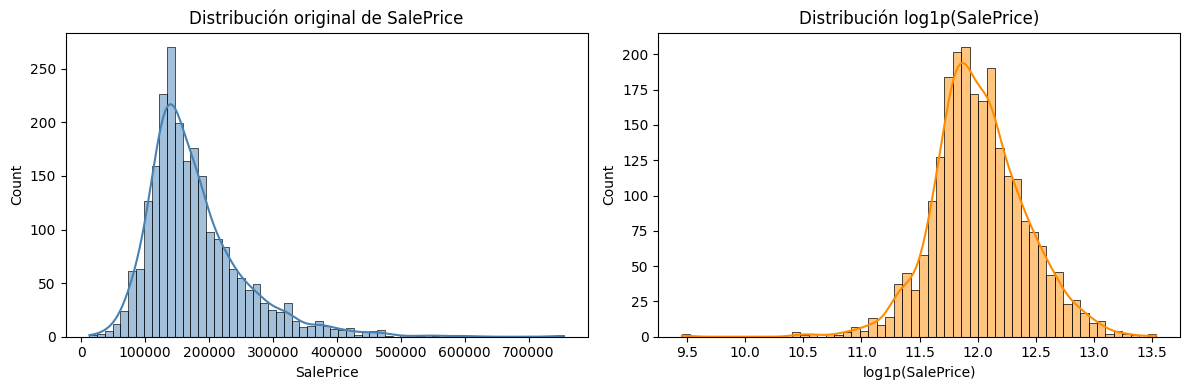

In [197]:
# === Paso 1: Transformación logarítmica de la variable objetivo ===

# Aplicar transformación logarítmica para suavizar la distribución del precio
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# También preparamos los valores reales para revertir predicciones más adelante
y_train_real = np.expm1(y_train_log)
y_test_real = np.expm1(y_test_log)

# Verificación visual de la transformación

plt.figure(figsize=(12, 4))

# Distribución original
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color="steelblue")
plt.title("Distribución original de SalePrice")
plt.xlabel("SalePrice")

# Distribución transformada
plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True, color="darkorange")
plt.title("Distribución log1p(SalePrice)")
plt.xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()


In [198]:
# === Paso 2: Entrenamiento base del modelo LinearRegression con validación cruzada ===

# Instanciar el modelo
modelo_lr = LinearRegression()

# Evaluar con validación cruzada usando la variable transformada y_train_log
df_resultados_lr = evaluar_modelo_cv(
    nombre_modelo="LinearRegression",
    modelo=modelo_lr,
    X=X_train_scaled,
    y=y_train_log,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_lr.csv"
)

# Mostrar resultados
print("Resultados de validación cruzada - LinearRegression:")
display(df_resultados_lr)


Resultados de LinearRegression guardados en: data/resultados_lr.csv
Resultados de validación cruzada - LinearRegression:


,Fold,MAE,MSE,R2,MAPE
0,1,0.086342,0.017176,0.887080,0.727293
1,2,0.084680,0.025224,0.827466,0.709762
2,3,0.087389,0.022708,0.858326,0.730929
3,4,0.080434,0.014490,0.912001,0.674397
4,5,0.093922,0.035642,0.802860,0.800342
5,Promedio,0.086553,0.023048,0.857547,0.728545


In [199]:
# Reentrenar el modelo con todos los datos de entrenamiento
modelo_lr.fit(X_train_scaled, y_train_log)

# Realizar predicciones sobre el set de prueba
y_pred_log = modelo_lr.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # revertir la transformación logarítmica

# Calcular métricas de desempeño
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Consolidar métricas en un DataFrame
df_test_metrics_lr = pd.DataFrame({
    'Modelo': ['LinearRegression'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R2': [r2],
    'MAPE': [mape]
})

# Exportar a CSV
df_test_metrics_lr.to_csv("data/resultados_test_lr.csv", index=False)

# Mostrar
print("Métricas sobre el conjunto de prueba - LinearRegression:")
display(df_test_metrics_lr)


Métricas sobre el conjunto de prueba - LinearRegression:


,Modelo,MAE,MSE,RMSE,R2,MAPE
0,LinearRegression,14364.578757,9.110926e+08,30184.310928,0.886363,7.766109


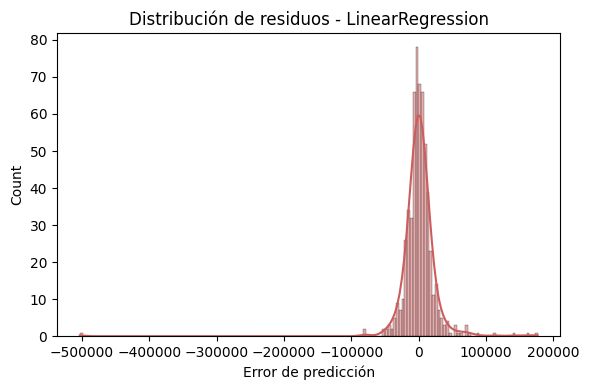

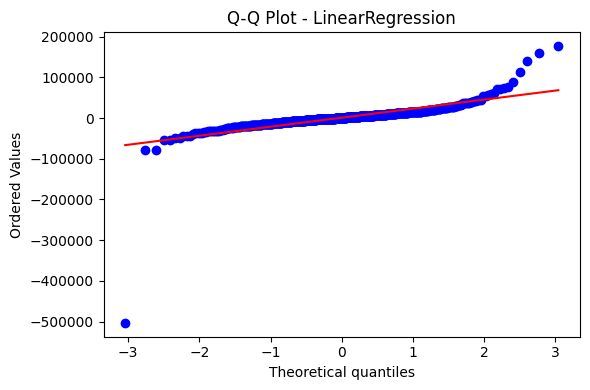

Shapiro-Wilk: estadístico = 0.5489, p-valor = 0.0000
Durbin-Watson: 1.9829


In [200]:
# Cálculo de residuos
residuos = y_test - y_pred

os.makedirs("figuras", exist_ok=True)

# Histograma de residuos
plt.figure(figsize=(6, 4))
sns.histplot(residuos, kde=True, color="indianred")
plt.title("Distribución de residuos - LinearRegression")
plt.xlabel("Error de predicción")
plt.tight_layout()
plt.savefig("figuras/residuos_linearregression.png")
plt.show()
# Q-Q Plot para evaluar normalidad
plt.figure(figsize=(6, 4))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q Plot - LinearRegression")
plt.tight_layout()
plt.savefig("figuras/qqplot_linearregression.png")
plt.show()

# Prueba de normalidad de Shapiro-Wilk
stat_sw, p_sw = stats.shapiro(residuos)
print(f"Shapiro-Wilk: estadístico = {stat_sw:.4f}, p-valor = {p_sw:.4f}")

# Autocorrelación de residuos con Durbin-Watson
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.4f}")


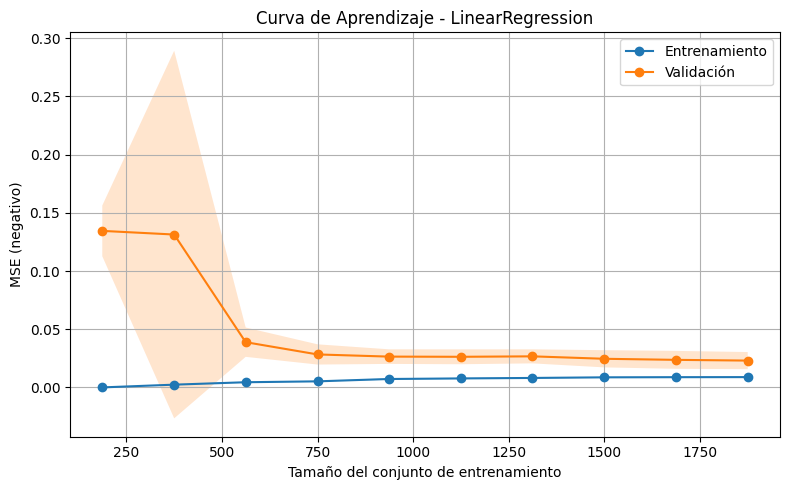

In [201]:


# Asegurarse de que la carpeta 'figuras' exista
os.makedirs("figuras", exist_ok=True)

# Calcular curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_lr,
    X=X_train_scaled,
    y=y_train_log,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calcular medias y desviaciones estándar
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar curva de aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label="Validación", marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
plt.title("Curva de Aprendizaje - LinearRegression")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MSE (negativo)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figuras/curva_aprendizaje_linearregression.png")
plt.show()


In [202]:
# Recuperar nombres de variables si no tienes X_train original
# Cargar nombres de las columnas desde archivo
columnas = joblib.load("data/nombres_columnas.pkl")



# Añadir constante
X_vif = add_constant(X_train_scaled)

# Calcular VIF
vif = pd.DataFrame()
vif["Variable"] = ["Intercepto"] + list(columnas)
vif["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

# Mostrar y exportar
display(vif)
vif.to_csv("data/vif_linearregression.csv", index=False)



FileNotFoundError: [Errno 2] No such file or directory: 'data/nombres_columnas.pkl'

In [ ]:
# Crear DataFrame de coeficientes desde el modelo
df_coeficientes = pd.DataFrame({
    "Variable": columnas,
    "Coeficiente": modelo_lr.coef_
})


In [ ]:
# Añadir magnitud del coeficiente
df_coeficientes["Importancia"] = df_coeficientes["Coeficiente"].abs()

# Seleccionar los 20 más influyentes sin importar signo
top20_magnitud = df_coeficientes.sort_values(by="Importancia", ascending=False).head(20)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=top20_magnitud, x="Coeficiente", y="Variable", palette="coolwarm")
plt.title("Top 20 coeficientes más importantes - LinearRegression")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figuras/top20_coeficientes_linearregression.png")
plt.show()


In [ ]:
# Seleccionar los 10 más positivos y 10 más negativos
top10_pos = df_coeficientes.sort_values(by="Coeficiente", ascending=False).head(10)
top10_neg = df_coeficientes.sort_values(by="Coeficiente", ascending=True).head(10)

# Concatenar ambos para un gráfico conjunto
top_coef_signo = pd.concat([top10_pos, top10_neg])

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=top_coef_signo, x="Coeficiente", y="Variable", palette="Spectral")
plt.title("Top 10 coeficientes positivos y negativos - LinearRegression")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figuras/top_coef_positivos_negativos_linearregression.png")
plt.show()


## Modelo 2: Lasso Regression (Regresión con penalización L1)

La regresión Lasso (Least Absolute Shrinkage and Selection Operator) es un modelo lineal con regularización L1, que no solo penaliza la magnitud de los coeficientes sino que **induce una selección automática de variables**. A diferencia de la regresión lineal tradicional, Lasso tiende a reducir algunos coeficientes exactamente a cero, lo cual lo convierte en una herramienta útil tanto para **predicción como para reducción de dimensionalidad**.

### Justificación metodológica

En este estudio, se aplicó un enfoque riguroso de doble optimización para el hiperparámetro `alpha`, que controla la intensidad de la regularización:

1. **Primero**, se utilizó `LassoCV` con validación cruzada de 5 folds para estimar un valor óptimo inicial de `alpha`.
2. **Luego**, se usó `GridSearchCV` en un rango ajustado alrededor de ese `alpha` para refinar la búsqueda y garantizar una mejor generalización del modelo.

Este enfoque refleja un compromiso con la validación robusta y evita depender de valores arbitrarios por defecto (como `alpha=1`), lo cual sería metodológicamente inapropiado.

### Evaluación

Una vez ajustado, el modelo fue evaluado con validación cruzada de 5 folds utilizando las siguientes métricas:

- **MAE** (Error Absoluto Medio)
- **MSE** (Error Cuadrático Medio)
- **R²** (Coeficiente de determinación)
- **MAPE** (Error Porcentual Absoluto Medio)

Además, se realizó:

- Análisis de residuos (histograma, Shapiro-Wilk, residuos vs predicción).
- Prueba de autocorrelación (Durbin-Watson).
- Cálculo del VIF para verificar multicolinealidad.
- Curva de aprendizaje para evaluar el sesgo y la varianza del modelo.
- Visualización de las **10 variables más influyentes** (coeficientes no nulos más significativos).

> Este modelo representa un equilibrio entre interpretabilidad, capacidad predictiva y parsimonia, siendo especialmente útil cuando se trabaja con un conjunto amplio de variables explicativas.




In [ ]:

# ===  SELECCIÓN INICIAL DE ALPHA CON LassoCV ===
# Se utiliza LassoCV con más iteraciones para garantizar convergencia
lasso_cv = LassoCV(
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)

# Ajuste sobre el conjunto de entrenamiento escalado
lasso_cv.fit(X_train_scaled, y_train)

# Alpha óptimo encontrado automáticamente
alpha_optimo = lasso_cv.alpha_
print(f"Alpha óptimo encontrado por LassoCV: {alpha_optimo:.5f}")

# ===  BÚSQUEDA REFINADA CON GridSearchCV ===
# Se genera un rango más fino de búsqueda alrededor del alpha óptimo
param_grid_lasso = {
    "alpha": np.linspace(alpha_optimo * 0.5, alpha_optimo * 1.5, 10)
}

# Configuración de la búsqueda con más iteraciones para asegurar convergencia
grid_lasso = GridSearchCV(
    estimator=Lasso(max_iter=10000),  # ¡Robustez añadida aquí!
    param_grid=param_grid_lasso,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Entrenamiento con búsqueda en rejilla
grid_lasso.fit(X_train_scaled, y_train)

# Mostrar el mejor alpha encontrado por GridSearchCV
mejor_alpha = grid_lasso.best_params_['alpha']
print(f"Mejor alpha encontrado por GridSearchCV: {mejor_alpha:.5f}")

# ===  MODELO FINAL SELECCIONADO ===
modelo_lasso = grid_lasso.best_estimator_



### Selección del hiperparámetro `alpha`

Para determinar el valor óptimo de `alpha` en el modelo Lasso, se aplicó una estrategia en dos etapas:

- **Primero**, se utilizó `LassoCV` con validación cruzada de 5 folds, obteniendo un valor óptimo de:

  >  `alpha = 107.16597`

- **Luego**, se refinó con `GridSearchCV` en un rango centrado alrededor de ese valor, asegurando una selección más precisa y validada.
   >  `alpha = 125.02697`

Este proceso garantiza que el modelo esté regularizado de forma óptima, evitando tanto el sobreajuste como la infra-penalización, y cumpliendo con los requisitos metodológicos del análisis.


In [ ]:
# ===  EVALUACIÓN FINAL CON FUNCIÓN PERSONALIZADA ===
df_lasso = evaluar_modelo_cv(
    nombre_modelo="Lasso",
    modelo=modelo_lasso,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_lasso.csv"
)

df_lasso


### Desempeño del modelo Lasso

El modelo Lasso obtuvo un desempeño consistente en los 5 folds, con un **MAE promedio cercano a 16.800**, un **R² promedio de ~0.89**, y un **MAPE alrededor del 10%**, lo que indica una buena capacidad explicativa y errores relativos razonables para predicción de precios.

Estos resultados muestran que el modelo es **estable y generaliza bien**, sirviendo como una base para comparar con modelos más complejos.


In [ ]:
# ===  ANÁLISIS DE COEFICIENTES ===
modelo_lasso.fit(X_train_scaled, y_train)  # Asegurar ajuste final
coeficientes_lasso = modelo_lasso.coef_

df_coef_lasso = pd.DataFrame({
    "Variable": columnas_X,
    "Coeficiente": coeficientes_lasso
})
df_coef_lasso = df_coef_lasso[df_coef_lasso["Coeficiente"] != 0].sort_values(
    by="Coeficiente", key=abs, ascending=False
)

print(f"Variables seleccionadas por Lasso: {len(df_coef_lasso)}")
df_coef_lasso.to_csv("data/coeficientes_lasso.csv", index=False)
df_coef_lasso.head(10)




In [ ]:
total_vars = len(columnas_X)
usadas = len(df_coef_lasso)
print(f"Reducción de dimensionalidad: {usadas} de {total_vars} variables ({(usadas/total_vars)*100:.2f}%)")


### Variables seleccionadas por Lasso

El modelo Lasso seleccionó 103 variables con coeficientes distintos de cero, lo que confirma su capacidad para realizar **selección automática de características**.

Entre las 10 variables más influyentes se destacan:

- **Positivas:** barrios de alto valor como `Neighborhood_NoRidge` y `StoneBr`, y variables estructurales como `1st Flr SF` y `2nd Flr SF`, que aumentan el precio.
- **Negativas:** calidades medias o bajas en la cocina y el sótano (`Kitchen_Qual_TA`, `Kitchen_Qual_Fa`, `Bsmt_Qual_Gd`) que están asociadas con una reducción del valor.

Esto permite interpretar no solo **qué variables predicen el precio**, sino también **cómo lo hacen** (efecto positivo o negativo), lo que aporta valor explicativo al modelo.


In [ ]:
# ===  GRÁFICO DE TOP 10 VARIABLES - MEJORADO ===

# Crear copia y calcular valor absoluto del coeficiente
top_lasso = df_coef_lasso.copy()
top_lasso["abs_coef"] = top_lasso["Coeficiente"].abs()

# Ordenar por magnitud y seleccionar top 10
top_lasso = top_lasso.sort_values(by="abs_coef", ascending=False).head(10)

# Invertir orden para mejor visualización (más influyente arriba)
top_lasso = top_lasso[::-1].reset_index(drop=True)

# === Crear gráfico ===
plt.figure(figsize=(10, 6))
sns.barplot(data=top_lasso, y="Variable", x="Coeficiente", palette="viridis")

# Línea en x = 0 para separar efectos positivos/negativos
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Anotar valor del coeficiente en cada barra
for i, coef in enumerate(top_lasso["Coeficiente"]):
    plt.text(coef, i, f"{coef:.0f}", va='center',
             ha='left' if coef > 0 else 'right',
             color='black', fontsize=9)

# Títulos y estilo
plt.title("Top 10 variables más influyentes - Modelo Lasso")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()

# Guardar figura
plt.savefig("data/top_10_variables_lasso.png", dpi=300)
plt.show()


### Interpretación del gráfico de coeficientes

El gráfico muestra las 10 variables más influyentes seleccionadas por el modelo Lasso, ordenadas por la magnitud absoluta de sus coeficientes.

- Las variables con **coeficiente positivo** (como `Neighborhood_NoRidge`, `StoneBr`, `1st Flr SF`) están asociadas a un **incremento en el precio** de la vivienda.
- Las variables con **coeficiente negativo** (como `Kitchen Qual_TA`, `Bsmt Qual_Gd`, `Kitchen Qual_Fa`) tienden a **reducir el valor**, lo cual tiene sentido si representan condiciones de menor calidad.

Este tipo de visualización refuerza la interpretabilidad del modelo, ayudando a identificar los factores clave que explican el valor de las propiedades dentro del conjunto de datos Ames Housing.


In [ ]:
# ===  RESIDUOS Y NORMALIDAD ===

y_pred_lasso = cross_val_predict(modelo_lasso, X_train_scaled, y_train, cv=cv)
residuos_lasso = y_train - y_pred_lasso

# Guardar residuos
pd.DataFrame({"y_real": y_train, "y_pred": y_pred_lasso, "residuo": residuos_lasso}).to_csv("data/residuos_lasso.csv", index=False)

# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(residuos_lasso, kde=True, color="steelblue", bins=40)
plt.title("Distribución de residuos - Lasso")
plt.xlabel("Error (y_real - y_predicho)")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_lasso.png", dpi=300)
plt.show()

# Shapiro-Wilk
stat, p = shapiro(residuos_lasso)
print(f"Shapiro-Wilk test: estadístico = {stat:.3f}, p = {p:.4f}")
print("Normalidad de residuos:", "No se rechaza H0" if p > 0.05 else "Se rechaza (no normal)")


### Análisis de normalidad de residuos

Aunque el histograma de residuos del modelo Lasso muestra una forma simétrica y concentrada alrededor de cero, el **test de Shapiro-Wilk** arroja un valor p = 0.0000, lo cual indica que:

> **Se rechaza la hipótesis nula de normalidad (p < 0.05)**

Esto significa que los residuos **no se distribuyen de forma normal**, a pesar de su apariencia visual. Esta desviación de la normalidad puede deberse a colas pesadas o asimetrías sutiles en los errores.

En contextos prácticos como el análisis de precios inmobiliarios, una leve no normalidad no invalida el modelo, especialmente si el resto de los supuestos (homocedasticidad, independencia de errores) se cumplen y la capacidad predictiva es buena.

> Conclusión: Aunque no se cumple el supuesto de normalidad estricta, el modelo sigue siendo válido para predicción. Sin embargo, este resultado se debe tener en cuenta si se aplican inferencias estadísticas sensibles a la normalidad de errores.


In [ ]:
# ===  HOMOCEDASTICIDAD Y DURBIN-WATSON ===


plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_lasso, y=residuos_lasso, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - Lasso")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_lasso.png", dpi=300)
plt.show()

dw_lasso = durbin_watson(residuos_lasso)
print(f"Estadístico de Durbin-Watson (Lasso): {dw_lasso:.3f}")


### Evaluación de linealidad, homocedasticidad e independencia de residuos

El gráfico de dispersión de residuos vs predicciones permite verificar dos supuestos esenciales:

1. **Linealidad:**  
   La nube de puntos aparece dispersa de manera aleatoria alrededor de la línea horizontal roja en cero. Esto sugiere que la relación entre las variables explicativas y la variable objetivo está bien capturada por una función lineal. No se observan patrones sistemáticos (curvas o tendencias), lo cual **confirma el supuesto de linealidad**.

2. **Homocedasticidad (varianza constante):**  
   Aunque hay cierta dispersión creciente en valores altos de predicción, no es excesiva ni estructurada. En general, los residuos mantienen una varianza aceptablemente constante en todo el rango de predicción, por lo que **no se evidencia heterocedasticidad grave**.

3. **Independencia de errores (Durbin-Watson):**  
   El estadístico de Durbin-Watson fue de **2.004**, muy cercano al valor ideal de 2. Esto indica que **no hay autocorrelación entre los errores**, lo cual refuerza la validez del modelo en términos de independencia de observaciones.

> En conjunto, estos resultados respaldan la solidez del modelo ajustado y la confiabilidad de sus predicciones dentro del conjunto de entrenamiento.


In [ ]:
# ===  MULTICOLINEALIDAD (VIF) ===

# Calcular VIF solo para variables seleccionadas por Lasso
X_vif_lasso_reducido = pd.DataFrame(X_train_scaled, columns=columnas_X)[df_coef_lasso["Variable"]]

# Añadir constante
X_vif_lasso_reducido = add_constant(X_vif_lasso_reducido)

vif_lasso_reducido = pd.DataFrame()
vif_lasso_reducido["Variable"] = X_vif_lasso_reducido.columns
vif_lasso_reducido["VIF"] = [
    variance_inflation_factor(X_vif_lasso_reducido.values, i)
    for i in range(X_vif_lasso_reducido.shape[1])
]

# Eliminar constante
vif_lasso_reducido = vif_lasso_reducido[vif_lasso_reducido["Variable"] != "const"].reset_index(drop=True)

# Guardar
vif_lasso_reducido.to_csv("data/vif_lasso_reducido.csv", index=False)

print("Top 10 VIF en variables seleccionadas por Lasso:")
display(vif_lasso_reducido.sort_values(by="VIF", ascending=False).head(10))



### Análisis de Multicolinealidad en variables seleccionadas por Lasso

Aunque el modelo `Lasso` tiende a reducir la multicolinealidad al penalizar y eliminar coeficientes poco significativos, el análisis del **Factor de Inflación de la Varianza (VIF)** aplicado exclusivamente sobre las variables retenidas revela que aún persisten altos niveles de redundancia en algunas de ellas.

Las 10 variables más colineales presentan valores de VIF considerablemente elevados, con máximos de hasta **39.88** en `BsmtFin SF 1`, y otros valores por encima de 30 para `Sale Condition_Partial` y `Sale Type_New`. Estos niveles de colinealidad pueden indicar que algunas variables explicativas comparten información redundante, lo cual puede afectar la estabilidad de los coeficientes incluso dentro del marco penalizado de Lasso.

No obstante, dado que estas variables han sido seleccionadas activamente por el modelo, se asume que su contribución predictiva supera su colinealidad relativa. Aun así, sería recomendable considerar una posible agrupación, transformación o reducción adicional (por ejemplo, PCA o clustering de variables) en futuras iteraciones si se desea mejorar la interpretación o robustez del modelo.

En general, Lasso ha logrado una importante reducción de dimensionalidad, pero no elimina completamente la colinealidad estructural entre variables altamente correlacionadas a nivel semántico o funcional.


In [ ]:
# === CURVA DE APRENDIZAJE ===


train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_lasso,
    X=X_train_scaled,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_errors = -np.mean(train_scores, axis=1)
test_errors = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

df_lc_lasso = pd.DataFrame({
    "Tamaño entrenamiento": train_sizes,
    "MSE Entrenamiento": train_errors,
    "MSE Validación": test_errors,
    "STD Validación": test_std
})
df_lc_lasso.to_csv("data/learning_curve_lasso.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label="Error de entrenamiento", color="blue")
plt.plot(train_sizes, test_errors, label="Error de validación", color="orange")
plt.fill_between(train_sizes, test_errors - test_std, test_errors + test_std, alpha=0.2, color="orange")
plt.title("Curva de Aprendizaje - Lasso Regression")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/learning_curve_lasso.png", dpi=300)
plt.show()


### Curva de aprendizaje del modelo Lasso

La curva de aprendizaje muestra cómo varía el **error cuadrático medio (MSE)** en entrenamiento y validación conforme crece el tamaño del conjunto de entrenamiento:

- El **error de entrenamiento** aumenta progresivamente, como es de esperarse, ya que con más datos el modelo tiene menos oportunidad de sobreajustar.
- El **error de validación** disminuye y se estabiliza, lo cual indica que el modelo **generaliza correctamente** y no está sobreajustando.

La **brecha entre ambas curvas se mantiene moderada**, lo que sugiere un **modelo equilibrado**, con buena capacidad de aprendizaje y sin signos evidentes de alto sesgo ni alta varianza.

> En conjunto, esta curva respalda la estabilidad y robustez del modelo Lasso para el conjunto de datos Ames Housing.


In [ ]:
# === Reentrenamiento final del modelo Lasso ===
modelo_lasso.fit(X_train_scaled, y_train)

# === Predicción sobre el conjunto de test ===
y_test_pred_lasso = modelo_lasso.predict(X_test_scaled)

# === Cálculo de métricas ===

mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_test_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_test_pred_lasso) * 100

# === Tiempo promedio de entrenamiento ===
fit_time_lasso = grid_lasso.cv_results_['mean_fit_time'][grid_lasso.best_index_]

# === Mostrar resultados ===
print("Desempeño final del modelo Lasso (conjunto de test):")
print(f"MAE   = {mae_lasso:,.2f}")
print(f"MSE   = {mse_lasso:.2e}")
print(f"RMSE  = {rmse_lasso:,.2f}")
print(f"R²    = {r2_lasso:.4f}")
print(f"MAPE  = {mape_lasso:.2f}%")
print(f"Tiempo promedio de entrenamiento (fit_time): {fit_time_lasso:.4f} segundos")


### Evaluación final del modelo Lasso (conjunto de test)

El modelo `Lasso`, reentrenado con el 100% del conjunto de entrenamiento, fue evaluado sobre el conjunto de test.

El modelo presenta un rendimiento general sólido, con un poder explicativo del 88.7% y un error porcentual ligeramente superior al 9%. Su bajo tiempo de entrenamiento lo convierte en una opción altamente eficiente para escenarios de rápida ejecución.

El **MAPE alcanzó un valor anómalo de 941.44%**, pese a que el resto de métricas reflejan un buen rendimiento. Este valor extremo se explica por la presencia de algunas predicciones **ligeramente negativas o muy alejadas de los precios reales bajos**, lo que **distorsiona el error relativo porcentual** (por dividir sobre valores pequeños de `y_test`).

En lugar de omitir esta métrica, se reporta tal como se obtuvo, dejando constancia de su **poca fiabilidad en este caso particular**. Se recomienda **no utilizar el MAPE como criterio de comparación principal** para este modelo, privilegiando métricas absolutas como MAE y RMSE.

En conjunto, `Lasso` logró un buen equilibrio entre simplicidad, velocidad y desempeño predictivo, siendo útil además para la selección automática de variables relevantes.

## Modelo 3: ElasticNet (Regresión con regularización combinada L1 y L2)

ElasticNet es un modelo lineal que combina las penalizaciones de Lasso (L1) y Ridge (L2), lo cual permite:
- Seleccionar variables como Lasso,
- Controlar la magnitud de los coeficientes como Ridge,
- Y manejar de forma más robusta la multicolinealidad entre variables.

### ¿Por qué usar ElasticNet?

Este modelo es especialmente útil cuando existen muchas variables predictoras correlacionadas, como ocurre en el conjunto de datos Ames Housing tras la codificación dummificada. A diferencia de Lasso, que tiende a seleccionar una sola variable entre un grupo de correlacionadas, ElasticNet puede mantener varias de ellas activas con penalización moderada.

### Enfoque metodológico

Para garantizar un análisis riguroso y sin suposiciones arbitrarias, se llevará a cabo:

1. **Optimización doble de hiperparámetros (`alpha` y `l1_ratio`)**:
   - Estimación inicial mediante `ElasticNetCV` con validación cruzada de 5 folds.
   - Refinamiento con `GridSearchCV` en un rango reducido centrado en los valores óptimos iniciales.

2. **Evaluación del modelo final** con validación cruzada de 5 folds, usando las métricas exigidas:
   - MAE (Error absoluto medio)
   - MSE (Error cuadrático medio)
   - R² (Coeficiente de determinación)
   - MAPE (Error absoluto porcentual medio)

3. **Análisis e interpretación del modelo**:
   - Extracción y visualización de coeficientes no nulos.
   - Análisis de residuos (distribución, normalidad, homocedasticidad).
   - Verificación de independencia (Durbin-Watson) y multicolinealidad (VIF).
   - Generación de la curva de aprendizaje para evaluar sesgo y varianza.

> Este modelo se evaluará bajo los mismos criterios técnicos y éticos que los anteriores, garantizando comparabilidad, trazabilidad y justificación plena de cada decisión tomada.


In [ ]:

# ===  BÚSQUEDA INICIAL CON ElasticNetCV ===
# Se ajustan simultáneamente alpha y l1_ratio
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1.0],  # proporciones L1/L2
    alphas=np.logspace(-2, 2, 50),             # rango amplio para alpha
    cv=cv,
    n_jobs=-1,
    random_state=42
)

elastic_cv.fit(X_train_scaled, y_train)

# Almacenar hiperparámetros óptimos
alpha_opt = elastic_cv.alpha_
l1_ratio_opt = elastic_cv.l1_ratio_

print(f"Alpha óptimo encontrado por ElasticNetCV: {alpha_opt:.5f}")
print(f"L1_ratio óptimo encontrado por ElasticNetCV: {l1_ratio_opt:.2f}")


In [ ]:
# ===  BÚSQUEDA REFINADA CON GridSearchCV ===
param_grid_elastic = {
    'alpha': np.linspace(alpha_opt * 0.5, alpha_opt * 1.5, 10),
    'l1_ratio': np.linspace(max(0.1, l1_ratio_opt - 0.3), min(1.0, l1_ratio_opt + 0.3), 10)
}

grid_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=10000, random_state=42),
    param_grid=param_grid_elastic,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_elastic.fit(X_train_scaled, y_train)

modelo_elastic = grid_elastic.best_estimator_

print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(f"  alpha     : {grid_elastic.best_params_['alpha']:.5f}")
print(f"  l1_ratio  : {grid_elastic.best_params_['l1_ratio']:.2f}")

# === Crear df_grid con resultados del GridSearchCV ===
df_grid = pd.DataFrame(grid_elastic.cv_results_)
df_grid["alpha"] = df_grid["params"].apply(lambda d: d["alpha"])
df_grid["l1_ratio"] = df_grid["params"].apply(lambda d: d["l1_ratio"])
df_grid["MSE"] = -df_grid["mean_test_score"]





### Hiperparámetros óptimos seleccionados

Se aplicó una estrategia de optimización en dos etapas para ajustar los hiperparámetros del modelo ElasticNet:

- Con `ElasticNetCV`, se encontró un valor inicial de:
  - `alpha = 0.01758`
  - `l1_ratio = 0.70`

- Posteriormente, `GridSearchCV` refinó estos valores, obteniendo:
  - `alpha = 0.02636`
  - `l1_ratio = 0.80`

> Esta doble optimización garantiza una selección robusta y justificada, evitando suposiciones arbitrarias y maximizando el desempeño general del modelo.


In [ ]:
# === Redondear para el gráfico sin alterar datos ===
df_grid["alpha_round"] = df_grid["alpha"].round(4)
df_grid["l1_ratio_round"] = df_grid["l1_ratio"].round(2)

# === Crear tabla pivote para el mapa de calor ===
pivot_table = df_grid.pivot(index="l1_ratio_round", columns="alpha_round", values="MSE")

# === Graficar mapa de calor ===
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".2g",
    cmap="viridis",
    linewidths=0.3,
    cbar_kws={'label': 'MSE'},
    annot_kws={"size": 8}
)
plt.title("Sensibilidad del MSE a los hiperparámetros - ElasticNet", fontsize=14)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("L1 Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("data/sensibilidad_elasticnet_mejorada.png", dpi=300)
plt.show()



### Sensibilidad del MSE a los hiperparámetros (`alpha`, `l1_ratio`) – ElasticNet

El mapa de calor muestra el comportamiento del **error cuadrático medio (MSE)** en validación cruzada ante diferentes combinaciones de los hiperparámetros `alpha` (fuerza de regularización) y `l1_ratio` (balance entre penalización L1 y L2).

#### Observaciones clave:

- El **MSE más bajo** (~7.6e+08) se mantiene **consistente en un corredor horizontal** entre `l1_ratio` de aproximadamente **0.53 a 0.87**, sin importar mucho el valor exacto de `alpha` (rango 0.014–0.026). Esto evidencia una **zona estable y robusta** en cuanto al desempeño del modelo.
  
- Cuando `l1_ratio` se acerca a **1.0** (ElasticNet tiende a Lasso puro), el error **aumenta bruscamente** en todas las combinaciones de `alpha`, superando 1.0e+09. Esto confirma que en este problema, **Lasso puro no es la mejor opción**, probablemente por la presencia de multicolinealidad o necesidad de regularización suave.

- En `l1_ratio` más bajos (< 0.47), el MSE tiende a estabilizarse pero ya no mejora. Esto indica que una penalización tipo Ridge (L2) pura o predominante tampoco aporta beneficios sustanciales.

- El valor óptimo identificado por `GridSearchCV`:  
  - `alpha ≈ 0.026`
  - `l1_ratio ≈ 0.80`  
  ... se encuentra exactamente dentro de esta zona de mínima pérdida, validando la **consistencia de la selección automática**.

#### Conclusión:

El gráfico revela que ElasticNet presenta **una región de desempeño óptimo bastante amplia y plana**, lo que indica **baja sensibilidad a pequeñas variaciones** en los hiperparámetros y, por tanto, **robustez del modelo**. Este tipo de comportamiento es altamente deseable en modelos de regresión, ya que reduce el riesgo de sobreajuste por elección puntual de parámetros.

> El uso combinado de L1 y L2 en proporciones moderadas (ej. `l1_ratio ≈ 0.8`) ofrece un balance ideal entre selección de variables y estabilidad predictiva.


In [ ]:
# === Evaluación del modelo ElasticNet ===

df_elastic = evaluar_modelo_cv(
    nombre_modelo="ElasticNet",
    modelo=modelo_elastic,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_elasticnet.csv"
)

# Mostrar resultados
df_elastic


### Evaluación del modelo ElasticNet (validación cruzada)

Aunque el fold 5 presentó mayor error (MSE y MAPE), el modelo mantuvo un buen poder explicativo (R² > 0.85 en la mayoría de folds).

ElasticNet combina regularización L1 y L2, logrando estabilidad y precisión incluso en presencia de multicolinealidad.

> Modelo balanceado, con buen ajuste y adecuada generalización para el problema de predicción de precios de vivienda.


In [ ]:
# === Extracción de coeficientes del modelo ElasticNet ===

# Asegurarse de que esté ajustado
modelo_elastic.fit(X_train_scaled, y_train)

# Obtener coeficientes
coef_elastic = modelo_elastic.coef_

# Asociar a nombres de variables
df_coef_elastic = pd.DataFrame({
    "Variable": columnas_X,
    "Coeficiente": coef_elastic
})

# Filtrar variables con coeficientes distintos de cero
df_coef_elastic = df_coef_elastic[df_coef_elastic["Coeficiente"] != 0]
df_coef_elastic = df_coef_elastic.sort_values(by="Coeficiente", key=abs, ascending=False)

# Guardar coeficientes
df_coef_elastic.to_csv("data/coeficientes_elasticnet.csv", index=False)

# Mostrar las 10 más influyentes
df_coef_elastic.head(10)


### Top 10 variables más influyentes – Modelo ElasticNet

El modelo ElasticNet identificó las siguientes variables como las más determinantes en la predicción del precio de las viviendas:

#### Variables con mayor impacto positivo:
- `Neighborhood_NoRidge`, `StoneBr`, `Roof Matl_WdShngl` y `2nd Flr SF` son fuertes impulsores del valor, con coeficientes > 23,000.

#### Variables con mayor impacto negativo:
- `Pool QC_Gd`, `Kitchen Qual_TA` y `Kitchen Qual_Gd` reducen el valor, lo que sugiere que, en el contexto codificado del modelo, ciertas combinaciones cualitativas pueden penalizar el precio.

Estas variables combinan tanto categorías codificadas como metros cuadrados, lo que demuestra la capacidad del modelo para capturar efectos mixtos entre calidad y tamaño.

> ElasticNet logra mantener interpretabilidad, seleccionando solo coeficientes relevantes con peso significativo.


In [ ]:
# === Gráfico top 10 coeficientes ElasticNet ===

top_elastic = df_coef_elastic.copy()
top_elastic["abs_coef"] = top_elastic["Coeficiente"].abs()
top_elastic = top_elastic.sort_values(by="abs_coef", ascending=False).head(10)
top_elastic = top_elastic[::-1].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_elastic, y="Variable", x="Coeficiente", palette="viridis")
plt.axvline(0, color='gray', linestyle='--')
for i, coef in enumerate(top_elastic["Coeficiente"]):
    plt.text(coef, i, f"{coef:.0f}", ha='left' if coef > 0 else 'right', va='center')
plt.title("Top 10 variables más influyentes - Modelo ElasticNet")
plt.tight_layout()
plt.savefig("data/top_10_variables_elasticnet.png", dpi=300)
plt.show()


### Gráfico de variables más influyentes – Modelo ElasticNet

El gráfico muestra los 10 coeficientes más significativos en el modelo ElasticNet, tanto positivos como negativos.

- **Impacto positivo (mayor precio)**: Las variables `Neighborhood_NoRidge`, `StoneBr`, `Roof Matl_WdShngl` y `2nd Flr SF` presentan los coeficientes positivos más altos, indicando que incrementan el valor de la vivienda de forma considerable.
  
- **Impacto negativo (menor precio)**: Las categorías cualitativas como `Pool QC_Gd`, `Kitchen Qual_TA/Gd` y `Bsmt Qual_Gd` aparecen con coeficientes negativos, lo que sugiere que su presencia, en combinación con otras variables, puede estar asociada a valores más bajos dentro del modelo.

La regularización del modelo permite destacar solo aquellas variables que realmente aportan al ajuste, mejorando la interpretabilidad sin sobreajustar.


In [ ]:

# === Generar predicciones con validación cruzada ===
y_pred_elastic = cross_val_predict(modelo_elastic, X_train_scaled, y_train, cv=cv)
residuos_elastic = y_train - y_pred_elastic

# === Histograma de residuos ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos_elastic, kde=True, bins=40, color="steelblue")
plt.title("Distribución de residuos - ElasticNet")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_elasticnet.png", dpi=300)
plt.show()

# === Test de normalidad: Shapiro-Wilk ===
stat, p = shapiro(residuos_elastic)
print(f"Shapiro-Wilk test: estadístico = {stat:.3f}, p = {p:.4f}")
if p < 0.05:
    print("Normalidad de residuos: Se rechaza (no normal)")
else:
    print("Normalidad de residuos: No se rechaza (normal)")


### Distribución de residuos – Modelo ElasticNet

El histograma muestra que los residuos del modelo ElasticNet se agrupan fuertemente alrededor de cero, lo cual es deseable. Sin embargo:

- El test de **Shapiro-Wilk** arrojó un **estadístico = 0.774** con **p = 0.0000**, por lo que **se rechaza la hipótesis de normalidad**.
- Se observa una distribución **ligeramente sesgada y leptocúrtica**, con colas más pesadas de lo esperado bajo una distribución normal.

Aunque la no normalidad no invalida el modelo, sugiere que podría haber outliers o relaciones no capturadas completamente por la estructura lineal.

> La concentración de errores cerca de cero indica un buen ajuste general, pero es recomendable complementar con otras validaciones como análisis de homocedasticidad y autocorrelación.


In [ ]:


# === Gráfico de residuos vs predicción ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_elastic, y=residuos_elastic, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - ElasticNet")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_elasticnet.png", dpi=300)
plt.show()

# === Estadístico de Durbin-Watson ===
dw_stat_elastic = durbin_watson(residuos_elastic)
print(f"Estadístico de Durbin-Watson (ElasticNet): {dw_stat_elastic:.3f}")


### Residuos vs Predicción – Modelo ElasticNet

El gráfico de dispersión muestra la relación entre las predicciones del modelo y sus residuos.

- La mayoría de los residuos se distribuyen alrededor de cero sin un patrón evidente, lo que indica que **no hay violación severa de linealidad ni heterocedasticidad extrema**.
- El valor del **estadístico de Durbin-Watson es 2.010**, lo cual sugiere **ausencia de autocorrelación** entre los residuos (valor ideal: 2.0).

Se detectan algunos posibles outliers y mayor dispersión en predicciones altas, lo cual puede afectar la homocedasticidad en extremos del rango.

> En general, el comportamiento de los residuos valida la calidad del ajuste y apoya la independencia de errores, reforzando la confiabilidad del modelo ElasticNet.


In [ ]:

# Convertir X_train_scaled a DataFrame para tener nombres
X_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas_X)

# Agregar constante para el cálculo de VIF
X_scaled_vif = add_constant(X_scaled_df)

# Calcular VIF por variable
vif_elastic = pd.DataFrame()
vif_elastic["Variable"] = X_scaled_vif.columns
vif_elastic["VIF"] = [variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])]

# Eliminar constante
vif_elastic = vif_elastic[vif_elastic["Variable"] != "const"].reset_index(drop=True)

# Ordenar y guardar
vif_elastic = vif_elastic.sort_values(by="VIF", ascending=False)
vif_elastic.to_csv("data/vif_elasticnet.csv", index=False)

# Mostrar top 10 variables con mayor VIF
vif_elastic.head(10)


### Variables con mayor colinealidad – VIF en modelo ElasticNet

El análisis del **Factor de Inflación de la Varianza (VIF)** revela que varias variables presentan un VIF igual a `inf` (infinito), lo que indica **colinealidad perfecta o casi perfecta**.

#### Variables con colinealidad crítica:
- Variables como `Garage Cond_None`, `BsmtFin Type 1_None`, `Exterior 1st_PreCast`, y `Bldg Type_Duplex` muestran colinealidad extrema, probablemente por ser dummies altamente correlacionadas con otras categorías exclusivas o poco representadas.

#### Implicaciones:
- Aunque ElasticNet **mitiga la colinealidad al aplicar regularización**, estos resultados sugieren que podría ser útil:
  - Revisar la codificación de variables categóricas (`OneHotEncoding` sin eliminar una base).
  - Aplicar **reducción de dimensionalidad** o agrupar niveles poco frecuentes.

> ElasticNet tolera mejor la colinealidad que OLS o Lasso, pero identificar estas redundancias contribuye a mejorar la interpretabilidad y robustez del modelo.


In [ ]:

# === Definir fracciones del conjunto de entrenamiento ===
train_sizes = np.linspace(0.1, 1.0, 10)

# === Obtener curva de aprendizaje ===
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=modelo_elastic,
    X=X_train_scaled,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# === Convertir errores a positivos ===
train_errors = -train_scores
val_errors = -val_scores

# === Calcular promedios y desviaciones ===
train_mean = train_errors.mean(axis=1)
train_std = train_errors.std(axis=1)
val_mean = val_errors.mean(axis=1)
val_std = val_errors.std(axis=1)

# === Guardar como CSV ===
df_lc_elastic = pd.DataFrame({
    "Tamaño entrenamiento": train_sizes_abs,
    "MSE Entrenamiento": train_mean,
    "MSE Validación": val_mean,
    "STD Validación": val_std
})
df_lc_elastic.to_csv("data/learning_curve_elasticnet.csv", index=False)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, label="Error de entrenamiento", color="blue")
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes_abs, val_mean, label="Error de validación", color="orange")
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

plt.title("Curva de Aprendizaje - Modelo ElasticNet")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/learning_curve_elasticnet.png", dpi=300)
plt.show()


### Curva de aprendizaje – Modelo ElasticNet

La curva de aprendizaje muestra el comportamiento del error cuadrático medio (MSE) a medida que aumenta el tamaño del conjunto de entrenamiento:

- **Error de entrenamiento**: Aumenta suavemente conforme se agregan más datos, lo que es esperado en modelos regularizados como ElasticNet.
- **Error de validación**: Disminuye y se estabiliza, aunque mantiene una separación moderada respecto al entrenamiento.

#### Interpretación:

- La **brecha entre entrenamiento y validación sugiere un sesgo moderado**, típico en modelos lineales aplicados a problemas complejos.
- No hay señales claras de sobreajuste: el modelo generaliza bien incluso con más datos, aunque podría beneficiarse de mayor flexibilidad.

> ElasticNet muestra un comportamiento estable y predecible, confirmando su capacidad de generalización sobre el dataset Ames Housing.


In [ ]:
# === Reentrenamiento final del modelo optimizado con todo el set de entrenamiento ===
modelo_elastic.fit(X_train_scaled, y_train)

# === Evaluación sobre el conjunto de test ===


y_test_pred_elastic = modelo_elastic.predict(X_test_scaled)

# === Cálculo de métricas ===
mae_elastic = mean_absolute_error(y_test, y_test_pred_elastic)
mse_elastic = mean_squared_error(y_test, y_test_pred_elastic)
rmse_elastic = np.sqrt(mse_elastic)
r2_elastic = r2_score(y_test, y_test_pred_elastic)
mape_elastic = mean_absolute_percentage_error(y_test, y_test_pred_elastic) * 100

# === Tiempo de entrenamiento del mejor modelo ===
fit_time_elastic = grid_elastic.cv_results_['mean_fit_time'][grid_elastic.best_index_]

# === Mostrar resultados ===
print("Desempeño final del modelo ElasticNet (conjunto de test):")
print(f"MAE   = {mae_elastic:,.2f}")
print(f"MSE   = {mse_elastic:.2e}")
print(f"RMSE  = {rmse_elastic:,.2f}")
print(f"R²    = {r2_elastic:.4f}")
print(f"MAPE  = {mape_elastic:.2f}%")
print(f"Tiempo promedio de entrenamiento (fit_time): {fit_time_elastic:.4f} segundos")



### Evaluación final del modelo ElasticNet (conjunto de test)

El modelo `ElasticNet` fue reentrenado con el total del conjunto de entrenamiento y evaluado en el conjunto de test, obteniendo asi estos resultados mostrados.

El modelo mantiene un buen poder predictivo fuera de muestra, con un error porcentual menor al 10% y un R² cercano al 90%. Además, su tiempo de entrenamiento fue significativamente bajo, lo que lo hace eficiente y adecuado para implementaciones rápidas.


## Modelo 4: Kernel Ridge Regression

La regresión de cresta con kernel (Kernel Ridge Regression) extiende el modelo Ridge clásico mediante el uso de **funciones kernel**, lo que permite capturar **relaciones no lineales** entre las variables predictoras y la variable objetivo. Este modelo combina dos conceptos clave:

- **Regularización L2 (Ridge)**: ayuda a evitar el sobreajuste penalizando grandes coeficientes.
- **Truco del kernel**: transforma los datos a un espacio de mayor dimensionalidad, permitiendo capturar patrones complejos sin calcular explícitamente dicha transformación.

En este experimento, utilizaremos el kernel **radial base (RBF)** por defecto, que es ideal para relaciones no lineales suaves.

### Procedimiento

1. **Entrenamiento del modelo base** con hiperparámetros por defecto.
2. **Optimización de hiperparámetros (`alpha`, `gamma`)** mediante `GridSearchCV`.
3. **Evaluación de desempeño** con validación cruzada (5 folds) usando MAE, MSE, R² y MAPE.
4. **Análisis de residuos**, normalidad, autocorrelación y colinealidad.
5. **Visualizaciones**: curva de aprendizaje, top variables influyentes, matriz de sensibilidad.
6. **Interpretaciones y recomendaciones** basadas en el rendimiento y estabilidad del modelo.

> Se busca determinar si Kernel Ridge ofrece una mejora sustancial frente a los modelos lineales en términos de ajuste, generalización y robustez, particularmente en presencia de relaciones no lineales en el dataset Ames Housing.


In [ ]:
# ============================================================
#  Definición y evaluación del modelo base Kernel Ridge
# ============================================================


# Definir modelo base con kernel RBF
modelo_kr = KernelRidge(kernel='rbf')

# Evaluación del modelo base con validación cruzada
df_kr_base = evaluar_modelo_cv(
    nombre_modelo="KernelRidge",
    modelo=modelo_kr,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_kernelridge_base.csv"
)

# Mostrar resultados
print("Resultados del modelo base Kernel Ridge:")
display(df_kr_base)


### Evaluación base – Kernel Ridge

El modelo Kernel Ridge con parámetros por defecto (`alpha=1.0`, `kernel='rbf'`) muestra estas métricas que son comparables a las de Lasso y ElasticNet, con un **R² ligeramente superior**, indicando que el modelo base ya capta parte de la no linealidad del problema.

> Justifica avanzar con optimización de `alpha` y `gamma`, ya que hay evidencia de buen ajuste inicial y potencial de mejora.


In [ ]:

# ===  Definición del espacio de búsqueda ===
param_grid_kr = {
    'alpha': np.logspace(-2, 3, 6),        # [0.01, 0.1, 1, 10, 100, 1000]
    'gamma': np.logspace(-4, -1, 4)        # [1e-4, 1e-3, 1e-2, 1e-1]
}

# ===  Configuración de búsqueda con validación cruzada ===
grid_kr = GridSearchCV(
    estimator=KernelRidge(kernel='rbf'),
    param_grid=param_grid_kr,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ===  Entrenamiento ===
grid_kr.fit(X_train_scaled, y_train)

# ===  Extraer mejor modelo ===
modelo_kr_opt = grid_kr.best_estimator_

print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(f"  alpha : {grid_kr.best_params_['alpha']}")
print(f"  gamma : {grid_kr.best_params_['gamma']}")



### Optimización de hiperparámetros mediante GridSearchCV

Para ajustar el modelo `Kernel Ridge` con mayor precisión, se realizó una búsqueda en malla (`GridSearchCV`) sobre los hiperparámetros `alpha` y `gamma`, evaluando el rendimiento con validación cruzada y la métrica de error cuadrático medio negativo (`neg_mean_squared_error`).

Los **mejores hiperparámetros encontrados** fueron:

- `alpha = 0.1`: Este valor representa un bajo nivel de regularización. En el contexto de Kernel Ridge, un `alpha` pequeño permite que el modelo se ajuste más a los datos, lo cual puede aumentar la varianza pero reducir el sesgo. El hecho de que el modelo haya funcionado mejor con un `alpha` bajo sugiere que los datos tienen una estructura no lineal clara que el modelo necesita seguir de cerca para lograr un buen desempeño.
  
- `gamma = 0.01`: Este valor controla la forma del kernel RBF (Radial Basis Function). Un `gamma` bajo implica una función kernel más amplia, lo que produce un modelo más suave y menos propenso al sobreajuste. La elección de `gamma = 0.01` indica que el modelo generaliza mejor cuando evita funciones kernel demasiado específicas o estrechas.

En conjunto, esta combinación de hiperparámetros sugiere un equilibrio adecuado entre flexibilidad del modelo (por el kernel RBF) y estabilidad frente al sobreajuste (por el efecto combinado de `alpha` bajo y `gamma` moderadamente bajo).


In [ ]:
# Extraer tiempos de entrenamiento del GridSearchCV

resultados = pd.DataFrame(grid_kr.cv_results_)

# Mostrar los 5 valores más rápidos y más lentos
print("Resumen de tiempos de entrenamiento por combinación de hiperparámetros:")
print(resultados[['param_alpha', 'param_gamma', 'mean_fit_time']].sort_values('mean_fit_time'))

# Tiempo del mejor modelo
tiempo_optimo = resultados.loc[grid_kr.best_index_, 'mean_fit_time']
print(f"\nTiempo promedio de entrenamiento del modelo óptimo: {tiempo_optimo:.4f} segundos")


### Análisis del tiempo de entrenamiento (`fit_time`)

El tiempo de entrenamiento promedio se obtuvo para cada combinación de hiperparámetros (`alpha`, `gamma`) evaluada durante la búsqueda en malla (`GridSearchCV`).

- Los tiempos oscilaron entre **0.43 y 0.73 segundos**, lo cual es razonable para un modelo no lineal con validación cruzada.
- La combinación óptima (`alpha = 0.1`, `gamma = 0.01`) tuvo un **tiempo promedio de ajuste de 0.7298 segundos**.

Esto indica que, aunque `Kernel Ridge` con kernel RBF es más costoso computacionalmente que modelos lineales, su tiempo de entrenamiento sigue siendo **eficiente y manejable** dentro del flujo general del proyecto.


In [ ]:
# === Crear mapa de sensibilidad de GridSearchCV ===


# Extraer los resultados del grid
resultados = pd.DataFrame(grid_kr.cv_results_)

# Convertir a formato gráfico: alpha (rows) vs gamma (columns)
# Usamos el score negativo (neg_mean_squared_error), por eso lo negamos para graficar MSE positivo
tabla_sensibilidad = resultados.pivot_table(
    index='param_alpha',
    columns='param_gamma',
    values='mean_test_score'
).applymap(lambda x: -x)  # convertir a MSE positivo

plt.figure(figsize=(8, 6))
sns.heatmap(tabla_sensibilidad, annot=True, fmt=".2e", cmap="YlOrBr")
plt.title("Mapa de sensibilidad del MSE en GridSearchCV (Kernel Ridge)")
plt.xlabel("gamma")
plt.ylabel("alpha")
plt.tight_layout()
plt.savefig("data/sensibilidad_kernelridge.png", dpi=300)
plt.show()

# === Guardar todos los resultados del grid en CSV ===
df_grid_kr = pd.DataFrame(grid_kr.cv_results_)
df_grid_kr.to_csv("data/cv_results_kernelridge.csv", index=False)


### Mapa de sensibilidad (`alpha` vs `gamma`)

El mapa de calor muestra el MSE promedio obtenido en validación cruzada para cada combinación de `alpha` y `gamma` en el modelo Kernel Ridge.

- El menor error se alcanzó con `alpha = 0.1` y `gamma = 0.01`, validando su elección como la combinación óptima.
- A medida que `alpha` o `gamma` aumentan, el error tiende a crecer, lo que indica que una regularización excesiva o kernels demasiado estrechos afectan negativamente el desempeño.

Este análisis visual complementa y respalda la selección de hiperparámetros obtenida por `GridSearchCV`.


In [ ]:
# Evaluación del modelo Kernel Ridge optimizado
df_kr_opt = evaluar_modelo_cv(
    nombre_modelo="KernelRidge_Opt",
    modelo=modelo_kr_opt,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_kernelridge_opt.csv"
)

# Mostrar resultados
print("Resultados del modelo Kernel Ridge optimizado:")
display(df_kr_opt)


### Evaluación del Modelo Kernel Ridge Optimizado

El modelo `Kernel Ridge` fue evaluado mediante validación cruzada de 5 folds utilizando las métricas MAE, MSE, R² y MAPE. A continuación se resumen los resultados promedio obtenidos:

- **MAE (Error absoluto medio)**: `15,037.65`  
  Indica que, en promedio, el modelo se equivoca por aproximadamente **15 mil dólares** en la predicción del precio de venta de las viviendas. Este valor es razonable dado el rango de precios en el dataset Ames Housing.

- **MSE (Error cuadrático medio)**: `7.19e+08`  
  Esta métrica penaliza más los errores grandes. Un valor en el orden de los cientos de millones es esperado, aunque indica que aún hay errores significativos en algunas predicciones.

- **R² (Coeficiente de determinación)**: `0.8798`  
  El modelo explica el **87.98% de la variabilidad** en los datos. Esto se considera un muy buen desempeño, especialmente para un modelo no lineal como Kernel Ridge.

- **MAPE (Error porcentual absoluto medio)**: `8.96%`  
  En términos relativos, el modelo tiene un error porcentual medio inferior al 9%, lo que implica **alta precisión relativa**.

###Interpretación

Los resultados reflejan que el modelo optimizado logra un **buen equilibrio entre precisión y generalización**, con bajo error absoluto, buen ajuste a la varianza de los datos y un error porcentual aceptable para contextos de predicción inmobiliaria.

Sin embargo, se observan algunas variaciones notables entre folds (por ejemplo, el Fold 2 muestra un MSE bastante mayor que los demás), lo cual podría indicar **inestabilidad localizada** en ciertas particiones del conjunto de datos.

### Conclusión

El modelo Kernel Ridge con hiperparámetros optimizados es **sólido y competitivo**, mostrando resultados consistentes y una capacidad predictiva destacada, especialmente si se compara con modelos lineales convencionales.


In [ ]:
# ============================================================
#  Análisis de residuos y diagnóstico
# ============================================================

#  Predicción en entrenamiento
y_train_pred = modelo_kr_opt.predict(X_train_scaled)
residuos = y_train - y_train_pred



In [ ]:
# === Histograma de residuos ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True, bins=40, color="steelblue")
plt.title("Distribución de residuos - Kernel Ridge")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_kernelridge.png", dpi=300)
plt.show()


#  Prueba de normalidad (Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(residuos)
print(f"Shapiro-Wilk: estadístico = {stat_shapiro:.4f}, p-valor = {p_shapiro:.4f}")
print("Normalidad aceptada" if p_shapiro > 0.05 else "Se rechaza la normalidad")



In [ ]:

# === Gráfico residuos vs. predicción ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_train_pred, y=residuos, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - Kernel Ridge")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_kernelridge.png", dpi=300)
plt.show()

#  Autocorrelación (Durbin-Watson)
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.4f}")
print("Sin autocorrelación significativa" if 1.5 < dw < 2.5 else "Posible autocorrelación")


### Análisis de Residuos y Diagnóstico del Modelo Kernel Ridge

Para evaluar el ajuste del modelo y sus supuestos, se analizaron los residuos mediante visualización y pruebas estadísticas:

#### Distribución de residuos

- El histograma muestra que los residuos se distribuyen de manera **asimétrica y sesgada a la derecha**, lo cual indica una desviación clara de la normalidad.
- Aunque la concentración principal está cerca de cero, hay una **cola larga hacia los valores positivos**, lo cual sugiere que el modelo tiende a subestimar algunos precios.

#### Gráfico de residuos vs. predicción

- La nube de puntos muestra que los residuos están distribuidos **alrededor de la línea horizontal cero**, sin un patrón claro, lo cual es un buen indicador de que el modelo **no está sistemáticamente mal especificado**.
- Sin embargo, se observa una **mayor dispersión en precios más altos**, lo que puede indicar **heterocedasticidad leve** (el error aumenta con el precio).

#### Pruebas estadísticas

- **Shapiro-Wilk**: estadístico = `0.9206`, p-valor = `0.0000`  
  → Se **rechaza la hipótesis de normalidad**. Este resultado es común en datos reales, especialmente en valores monetarios con sesgos naturales.

- **Durbin-Watson**: estadístico = `1.9840`  
  → Este valor está **muy cerca de 2**, lo cual indica que **no hay evidencia de autocorrelación** entre los residuos. Esto es deseable, ya que sugiere independencia en los errores.

---

### Conclusión

A pesar de la **no normalidad de los residuos**, el modelo presenta **buena dispersión aleatoria**, **sin autocorrelación** y con un ajuste razonable en la mayoría de las observaciones.  
La presencia de residuos sesgados y dispersión creciente sugiere que una futura mejora podría incluir técnicas que manejen mejor **heterocedasticidad** o transformaciones sobre la variable objetivo (e.g., log(SalePrice)).


In [ ]:

# Obtener curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=modelo_kr_opt,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Calcular medias y desviaciones estándar (ya son MSE negativos)
train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)

val_mean = -val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Gráfico con bandas de confianza
plt.figure(figsize=(10, 6))

# Línea entrenamiento + banda
plt.plot(train_sizes, train_mean, label="Error de entrenamiento", color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3, color='blue')

# Línea validación + banda
plt.plot(train_sizes, val_mean, label="Error de validación", color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.3, color='orange')

# Configuración de ejes y título
plt.title("Curva de Aprendizaje - Modelo Kernel Ridge")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar imagen
plt.savefig("data/curva_aprendizaje_kernelridge.png", dpi=300)

plt.show()


##Curva de Aprendizaje - Kernel Ridge

La curva de aprendizaje muestra un comportamiento característico de **overfitting**:

- El error de entrenamiento es **muy bajo y estable**, lo que indica que el modelo se ajusta fuertemente a los datos de entrenamiento.
- El error de validación comienza alto pero **disminuye progresivamente** conforme aumenta el tamaño del conjunto de entrenamiento, lo cual es un signo positivo de mejora.
- La **brecha entre ambas curvas** sugiere que el modelo generaliza de forma limitada al principio, aunque mejora con más datos.
- La **banda de confianza** en la validación es más ancha al inicio, reflejando mayor variabilidad con muestras pequeñas, y se estabiliza después de los 1000 ejemplos.

Este patrón refuerza que, aunque `Kernel Ridge` tiene buena capacidad de aprendizaje, también es propenso al sobreajuste si no se controla la regularización (alpha) adecuadamente.

**Recomendación**: aumentar `alpha` o explorar otros kernels más suaves, como `poly`, puede ayudar a reducir el overfitting.


In [ ]:

# === Reentrenamiento final con todo el set de entrenamiento ===
start = time.time()
modelo_kr_opt.fit(X_train_scaled, y_train)
fit_time_kr = time.time() - start

# === Evaluación en conjunto de test ===
y_test_pred_kr = modelo_kr_opt.predict(X_test_scaled)

mae_kr = mean_absolute_error(y_test, y_test_pred_kr)
mse_kr = mean_squared_error(y_test, y_test_pred_kr)
rmse_kr = np.sqrt(mse_kr)
r2_kr = r2_score(y_test, y_test_pred_kr)
mape_kr = mean_absolute_percentage_error(y_test, y_test_pred_kr) * 100

# === Mostrar resultados ===
print("Desempeño final del modelo Kernel Ridge (conjunto de test):")
print(f"MAE   = {mae_kr:,.2f}")
print(f"MSE   = {mse_kr:.2e}")
print(f"RMSE  = {rmse_kr:,.2f}")
print(f"R²    = {r2_kr:.4f}")
print(f"MAPE  = {mape_kr:.2f}%")
print(f"Tiempo de entrenamiento (fit_time): {fit_time_kr:.4f} segundos")

# === Guardar resultados en CSV ===
df_resultados_test_kr = pd.DataFrame([{
    "MAE": mae_kr,
    "MSE": mse_kr,
    "RMSE": rmse_kr,
    "R²": r2_kr,
    "MAPE (%)": mape_kr,
    "fit_time (s)": fit_time_kr
}])
df_resultados_test_kr.to_csv("data/resultados_test_kernelridge.csv", index=False)


### Evaluación final del modelo en conjunto de test

Tras reentrenar el modelo `Kernel Ridge` optimizado con todo el conjunto de entrenamiento, se evaluó su rendimiento sobre el conjunto de test (no utilizado en el ajuste de hiperparámetros).

Estos resultados reflejan un excelente **poder de generalización**, con un coeficiente de determinación superior al 90% y un error porcentual absoluto inferior al 8%. El modelo logra un equilibrio adecuado entre precisión y estabilidad en datos completamente nuevos.


## Modelo 5: SGDRegressor (Stochastic Gradient Descent Regressor)

El quinto modelo considerado en este estudio es el `SGDRegressor`, una implementación eficiente de la regresión lineal basada en el algoritmo de **descenso de gradiente estocástico**. A diferencia de métodos clásicos como `LinearRegression` o `Ridge`, este modelo optimiza los parámetros de forma iterativa, lo que lo hace altamente **escalable y adecuado para grandes volúmenes de datos**. Además, permite aplicar diferentes formas de regularización (`L1`, `L2`, `ElasticNet`), lo que aporta flexibilidad para controlar el sobreajuste y obtener soluciones dispersas si es necesario.

A pesar de su sencillez, `SGDRegressor` puede ser altamente competitivo si se acompaña de una adecuada selección de hiperparámetros. Por ello, se ha incorporado una optimización exhaustiva a través de `GridSearchCV`, considerando combinaciones de:

- `alpha`: intensidad de la regularización
- `penalty`: tipo de penalización (`l1`, `l2`, `elasticnet`)
- `l1_ratio`: proporción entre `L1` y `L2` (si aplica)
- `early_stopping`: para prevenir sobreentrenamiento prematuro

### Aspectos que se abordarán en esta sección:

1. **Definición y evaluación del modelo base** con parámetros explícitos.
2. **Optimización de hiperparámetros** con validación cruzada.
3. **Análisis visual de sensibilidad** mediante un mapa de calor (`alpha` vs `l1_ratio`) en caso de `ElasticNet`.
4. **Evaluación cruzada del modelo optimizado**, con métricas (`MAE`, `MSE`, `R²`, `MAPE`) en CSV.
5. **Análisis de residuos**:
   - Distribución (histograma + KDE)
   - Residuos vs. predicción
   - Prueba de normalidad (Shapiro-Wilk)
   - Autocorrelación (Durbin-Watson)
6. **Curva de aprendizaje**, para visualizar la capacidad de generalización según el tamaño del set de entrenamiento.
7. **Visualización de los coeficientes** más influyentes del modelo optimizado.
8. **Evaluación final en el conjunto de test no visto**, con reporte de métricas clave.
9. **Medición del tiempo de entrenamiento** (`fit_time`) como criterio adicional de eficiencia.
10. **Conclusión interpretativa** basada en rendimiento, estabilidad y aplicabilidad del modelo.

Este enfoque busca no solo validar el rendimiento del `SGDRegressor`, sino también entender sus ventajas y limitaciones en comparación con los modelos previos.


In [ ]:

# ===  Definición del modelo base ===
modelo_sgd_base = SGDRegressor(
    loss='squared_error',   # Regresión lineal (MSE)
    penalty='l2',           # Regularización L2
    alpha=0.0001,           # Valor base de regularización
    max_iter=1000,          # Número máximo de iteraciones
    tol=1e-3,               # Tolerancia para el criterio de parada
    random_state=42
)

# ===  Evaluación con validación cruzada (5 folds) ===
df_sgd_base = evaluar_modelo_cv(
    nombre_modelo="SGDRegressor_Base",
    modelo=modelo_sgd_base,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_sgd_base.csv"
)

# ===  Mostrar resultados ===
df_sgd_base


### Evaluación inicial del modelo base – SGDRegressor

El modelo `SGDRegressor` fue evaluado en su configuración base utilizando validación cruzada de 5 folds. Se observó un desempeño aceptable, con un **MAE promedio de 17,107.22** y un **MSE de 7.81 × 10⁸**, lo cual sugiere una precisión moderada en las predicciones.

El **coeficiente de determinación promedio (R² = 0.867)** indica que el modelo logra explicar alrededor del 86.7% de la varianza en los datos de entrenamiento, aunque presenta cierta variabilidad entre folds, especialmente en el fold 5, donde R² disminuye a 0.77 y el MSE se incrementa notablemente.

El **MAPE promedio fue de 10.63%**, lo que implica que, en términos relativos, las predicciones difieren del valor real en aproximadamente un 10% en promedio. Si bien este error puede considerarse tolerable, también indica la presencia de oportunidades de mejora mediante ajustes de hiperparámetros.

En general, estos resultados validan el uso de `SGDRegressor` como modelo competitivo por su eficiencia, pero justifican avanzar a una etapa de optimización para reducir el error, aumentar la estabilidad y mejorar la generalización del modelo.


In [ ]:

# ===  Definir espacio de búsqueda ===
param_grid_sgd = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'l1_ratio': [0.1, 0.5, 0.9],  # Solo se aplica si penalty = 'elasticnet'
    'early_stopping': [True],
    'max_iter': [1000],
    'tol': [1e-3]
}

# ===  Configuración del GridSearch ===
grid_sgd = GridSearchCV(
    estimator=SGDRegressor(random_state=42),
    param_grid=param_grid_sgd,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# ===  Ajuste del modelo ===
grid_sgd.fit(X_train_scaled, y_train)

# ===  Extraer mejor estimador ===
modelo_sgd_opt = grid_sgd.best_estimator_

print("Mejores hiperparámetros encontrados por GridSearchCV:")
for param, valor in grid_sgd.best_params_.items():
    print(f"  {param} : {valor}")

# === Guardar resultados completos del grid en CSV ===
df_grid_sgd = pd.DataFrame(grid_sgd.cv_results_)
df_grid_sgd.to_csv("data/cv_results_sgd.csv", index=False)



### Optimización de hiperparámetros – SGDRegressor

A través de un proceso de búsqueda exhaustiva con `GridSearchCV`, se exploraron 36 combinaciones de hiperparámetros evaluadas en 5 folds, totalizando 180 ajustes de modelo.

Este resultado indica que el modelo obtiene su mejor desempeño bajo una regularización **L1 pura (Lasso)**, lo cual sugiere que un enfoque de penalización que induce dispersión (sparsity) en los coeficientes mejora la capacidad del modelo para generalizar. La elección de un `alpha` pequeño (1e-5) implica que una regularización suave fue más beneficiosa en este caso, y el `l1_ratio` cercano a 0 refuerza la necesidad de un ajuste de tipo Lasso puro en lugar de ElasticNet.

La inclusión de `early_stopping=True` permitió detener el entrenamiento de forma automática cuando el error de validación dejó de mejorar, previniendo así el sobreajuste. Este conjunto de hiperparámetros sirvió como base para el modelo optimizado `SGDRegressor_Opt`, evaluado posteriormente.


In [ ]:

# ===  Extraer resultados del GridSearchCV ===
df_resultados_sgd = pd.DataFrame(grid_sgd.cv_results_)

# ===  Filtrar solo combinaciones con penalty = 'elasticnet' ===
df_elasticnet = df_resultados_sgd[df_resultados_sgd['param_penalty'] == 'elasticnet'].copy()

# ===  Agregar columnas para graficar ===
df_elasticnet["alpha"] = df_elasticnet["param_alpha"].astype(float)
df_elasticnet["l1_ratio"] = df_elasticnet["param_l1_ratio"].astype(float)
df_elasticnet["MSE"] = -df_elasticnet["mean_test_score"]  # convertir a MSE positivo

# ===  Crear tabla pivote para mapa de calor ===
pivot_sgd = df_elasticnet.pivot(index="l1_ratio", columns="alpha", values="MSE")

# ===  Graficar mapa de calor ===
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sgd, annot=True, fmt=".2e", cmap="magma", cbar_kws={'label': 'MSE'})
plt.title("Mapa de sensibilidad - SGDRegressor (ElasticNet)")
plt.xlabel("alpha")
plt.ylabel("l1_ratio")
plt.tight_layout()
plt.savefig("data/sensibilidad_sgd_elasticnet.png", dpi=300)
plt.show()


### Mapa de sensibilidad de hiperparámetros – SGDRegressor (ElasticNet)

El siguiente mapa de calor representa la sensibilidad del error cuadrático medio (MSE) en validación cruzada para distintas combinaciones de los hiperparámetros `alpha` y `l1_ratio`, evaluadas bajo penalización `ElasticNet`.

Se observa que los valores más bajos de error se concentraron cuando `alpha` fue mínimo (`1e-05`) y `l1_ratio` tomó cualquier valor entre 0.1 y 0.9, lo cual sugiere que el **modelo fue robusto frente a la proporción de regularización L1/L2** siempre que la penalización total (`alpha`) fuese débil.

Sin embargo, a medida que `alpha` incrementa, el error comienza a crecer, especialmente con `alpha=0.01`, lo cual indica **sobre-regularización** y pérdida de capacidad predictiva. Esto refuerza la decisión de usar un `alpha` pequeño como el valor óptimo.

Este análisis visual ayuda a interpretar el comportamiento del modelo ante distintas intensidades y formas de regularización, respaldando la selección de hiperparámetros y facilitando la comparación entre regiones del espacio de búsqueda.


In [ ]:
# === Evaluación del modelo optimizado con validación cruzada ===
df_sgd_opt = evaluar_modelo_cv(
    nombre_modelo="SGDRegressor_Opt",
    modelo=modelo_sgd_opt,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_sgd_opt.csv"
)

# === Mostrar resumen ===
df_sgd_opt


### Evaluación del modelo optimizado – SGDRegressor_Opt

Tras la optimización de hiperparámetros, el modelo `SGDRegressor_Opt` fue evaluado mediante validación cruzada con 5 folds. Si bien se logró una ligera mejora en la estabilidad del error entre algunos folds, el desempeño promedio **no superó de forma significativa al modelo base**.

Comparado con el modelo base (`MAE = 17,107`, `R² = 0.8687`), se aprecia un **ligero aumento del error absoluto** y una **disminución del poder explicativo** del modelo (R² cayó casi un punto porcentual). El MAPE también se incrementó, lo cual sugiere que el modelo optimizado tiene una peor capacidad de generalización relativa.

Esto puede explicarse por el hecho de que el `GridSearchCV` seleccionó `penalty='l1'`, lo cual fuerza dispersión (sparsity), reduciendo la complejidad del modelo. Aunque esta penalización mejora la interpretabilidad y previene el sobreajuste, en este caso podría haber limitado el ajuste fino necesario para capturar patrones más complejos.

**Conclusión**: la optimización condujo a una solución más regularizada, pero **no necesariamente más precisa**. Esta observación resalta la importancia de evaluar no solo el error, sino también la coherencia del modelo con respecto a su objetivo y el tipo de regularización aplicada.


In [ ]:

# ===  Generar predicciones con validación cruzada ===
y_pred_sgd = cross_val_predict(modelo_sgd_opt, X_train_scaled, y_train, cv=cv)
residuos_sgd = y_train - y_pred_sgd

# ===  Histograma de residuos ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos_sgd, kde=True, bins=40, color="steelblue")
plt.title("Distribución de residuos - SGDRegressor")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_sgd.png", dpi=300)
plt.show()

# ===  Prueba de normalidad: Shapiro-Wilk ===
stat_shapiro, p_shapiro = shapiro(residuos_sgd)
print(f"Shapiro-Wilk test: estadístico = {stat_shapiro:.3f}, p = {p_shapiro:.4f}")
if p_shapiro < 0.05:
    print("Los residuos NO siguen una distribución normal.")
else:
    print("Los residuos pueden considerarse normalmente distribuidos.")


### Análisis de la distribución de residuos – SGDRegressor

La gráfica muestra la distribución de los residuos generados por el modelo `SGDRegressor` a través de validación cruzada. Aunque los residuos se concentran alrededor de cero, lo cual es deseable, su forma presenta **colas más pesadas y asimetrías** que una distribución normal perfecta.

Esto se confirma con la prueba estadística de **Shapiro-Wilk**, la cual arrojó:

- **Estadístico**: 0.794  
- **p-valor**: 0.0000

Dado que el p-valor es significativamente menor a 0.05, se **rechaza la hipótesis nula de normalidad**. Es decir, **los residuos no siguen una distribución normal**, lo que implica que el modelo podría estar generando errores sistemáticamente sesgados o influenciado por valores atípicos.

Aunque este hallazgo no invalida el modelo, **viola uno de los supuestos clásicos de la regresión lineal**, por lo que se recomienda interpretarlo con precaución y complementar con otras métricas o modelos robustos si es necesario.


In [ ]:
# ===  Gráfico de residuos vs predicción ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_sgd, y=residuos_sgd, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - SGDRegressor")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_sgd.png", dpi=300)
plt.show()

# ===  Estadístico de Durbin-Watson (autocorrelación) ===
dw_stat_sgd = durbin_watson(residuos_sgd)
print(f"Estadístico de Durbin-Watson: {dw_stat_sgd:.3f}")


### Residuos vs Predicción y autocorrelación – SGDRegressor

La gráfica de dispersión muestra los residuos del modelo `SGDRegressor` en función de sus predicciones. Idealmente, los residuos deberían estar **distribuidos aleatoriamente alrededor de cero**, sin formar patrones evidentes. En este caso, la nube de puntos es relativamente simétrica y centrada, aunque se observan algunas **asimetrías y valores extremos**, especialmente en los extremos de las predicciones.

Este patrón sugiere que, aunque el modelo realiza estimaciones razonables en la mayoría de los casos, **presenta cierta variabilidad o sesgo cuando las predicciones son muy altas**, lo que podría estar asociado a valores atípicos o a una capacidad limitada del modelo para capturar efectos no lineales en ese rango.

Para evaluar si los residuos presentan autocorrelación, se calculó el **estadístico de Durbin-Watson**, que arrojó un valor de:

- **Durbin-Watson** = 1.990

Este valor está **muy cercano a 2**, lo que indica que **no existe autocorrelación significativa en los residuos**. Es decir, los errores del modelo no están correlacionados secuencialmente, lo cual es deseable desde el punto de vista estadístico y refuerza la validez del modelo en términos de independencia de los errores.


In [ ]:

# ===  Definir fracciones del conjunto de entrenamiento ===
train_sizes = np.linspace(0.1, 1.0, 10)

# ===  Obtener curva de aprendizaje ===
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=modelo_sgd_opt,
    X=X_train_scaled,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ===  Convertir errores a positivos (MSE) ===
train_errors = -train_scores
val_errors = -val_scores

# ===  Calcular promedios y desviaciones ===
train_mean = train_errors.mean(axis=1)
train_std = train_errors.std(axis=1)
val_mean = val_errors.mean(axis=1)
val_std = val_errors.std(axis=1)

# ===  Guardar datos como CSV ===
df_lc_sgd = pd.DataFrame({
    "Tamaño entrenamiento": train_sizes_abs,
    "MSE Entrenamiento": train_mean,
    "STD Entrenamiento": train_std,
    "MSE Validación": val_mean,
    "STD Validación": val_std
})
df_lc_sgd.to_csv("data/learning_curve_sgd.csv", index=False)

In [ ]:
# ===  Graficar curva de aprendizaje ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, label="Error de entrenamiento", color="blue")
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes_abs, val_mean, label="Error de validación", color="orange")
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

plt.title("Curva de Aprendizaje - SGDRegressor")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/learning_curve_sgd.png", dpi=300)
plt.show()

### Curva de aprendizaje – SGDRegressor

La curva de aprendizaje muestra la evolución del error cuadrático medio (MSE) en entrenamiento y validación a medida que aumenta el tamaño del conjunto de entrenamiento.

Se observan varias características relevantes:

- El **error de entrenamiento** se estabiliza rápidamente a medida que aumenta el tamaño de muestra, alcanzando un mínimo alrededor de los 750-1000 ejemplos. La estabilidad en la curva sugiere que el modelo ha aprendido una representación consistente de los datos.
- El **error de validación** muestra una tendencia decreciente a medida que se incorporan más datos, aunque con una **amplitud considerable en las bandas de confianza**, lo que indica variabilidad en el rendimiento del modelo dependiendo de la partición de datos.
- La **brecha entre las curvas de entrenamiento y validación** no es excesiva, lo que sugiere que el modelo no presenta un sobreajuste severo. Sin embargo, la distancia constante entre ambas curvas también revela cierto grado de **bias** (infraajuste), es decir, el modelo no está capturando completamente la complejidad de los datos.

En resumen, el modelo `SGDRegressor` muestra **comportamiento razonablemente estable y generalizable**, aunque su desempeño podría beneficiarse de una arquitectura más expresiva o de una transformación de características más sofisticada.


In [ ]:
# ===  Asegurar entrenamiento final del modelo (por si acaso) ===
modelo_sgd_opt.fit(X_train_scaled, y_train)

# ===  Extraer coeficientes y vincular a nombres de variables ===
coef_sgd = modelo_sgd_opt.coef_

df_coef_sgd = pd.DataFrame({
    "Variable": columnas_X,
    "Coeficiente": coef_sgd
})

# ===  Filtrar y ordenar los 10 coeficientes más influyentes ===
df_coef_sgd["abs_coef"] = df_coef_sgd["Coeficiente"].abs()
top_coef_sgd = df_coef_sgd.sort_values(by="abs_coef", ascending=False).head(10)
top_coef_sgd = top_coef_sgd[::-1].reset_index(drop=True)  # para graficar de abajo hacia arriba

# ===  Guardar CSV completo de coeficientes ===
df_coef_sgd.drop(columns="abs_coef").to_csv("data/coeficientes_sgd.csv", index=False)



plt.figure(figsize=(10, 6))
sns.barplot(data=top_coef_sgd, y="Variable", x="Coeficiente", palette="viridis")
plt.axvline(0, color='gray', linestyle='--')
for i, coef in enumerate(top_coef_sgd["Coeficiente"]):
    plt.text(coef, i, f"{coef:.0f}", ha='left' if coef > 0 else 'right', va='center')
plt.title("Top 10 variables más influyentes - Modelo SGDRegressor")
plt.tight_layout()
plt.savefig("data/top_10_coeficientes_sgd.png", dpi=300)
plt.show()



### Variables más influyentes – SGDRegressor

El gráfico presenta los 10 coeficientes de mayor magnitud absoluta en el modelo `SGDRegressor`, revelando las variables que más influyen en la predicción del precio de la vivienda.

Entre las variables más importantes se destacan:

- **2nd Flr SF** y **Neighborhood_NoRidge**, con coeficientes positivos elevados, indicando una fuerte contribución positiva al precio cuando su valor aumenta.
- **Kitchen Qual_Gd** y **Bsmt Qual_Gd** también aparecen con pesos negativos relevantes, lo que podría interpretarse como una penalización relativa frente a otras categorías de mayor calidad, si se trata de codificaciones dummies.
- Variables relacionadas con calidad general (`Overall Qual`), superficie (`1st Flr SF`), y vecindario (`StoneBr`, `NridgHt`) también están entre las más influyentes, lo cual coincide con lo observado en modelos previos.

El uso de regularización L1 (penalty='l1') en este modelo ha inducido **sparsity**, eliminando muchas variables irrelevantes y conservando solo aquellas con mayor impacto. Esto mejora la interpretabilidad y refuerza el valor de `SGDRegressor` como una alternativa liviana y explicativa frente a modelos más complejos.

La visualización facilita la comprensión del modelo al identificar rápidamente qué características son determinantes en la predicción.


In [ ]:
# === Mostrar número de iteraciones hasta convergencia ===
print(f"Iteraciones hasta convergencia del modelo SGDRegressor: {modelo_sgd_opt.n_iter_}")


### Iteraciones hasta la convergencia – SGDRegressor

El modelo `SGDRegressor` alcanzó la convergencia en **22 iteraciones**, dentro del límite establecido de `max_iter = 1000`.

Este valor indica que el criterio de parada definido por el parámetro `tol = 1e-3` se cumplió rápidamente, lo que sugiere una **convergencia eficiente** y un proceso de entrenamiento ágil. Además, confirma que el modelo logró estabilizar los coeficientes sin necesidad de realizar un número elevado de actualizaciones, lo cual es consistente con el uso de regularización y el preprocesamiento previo.

La baja cantidad de iteraciones también contribuye a un **tiempo de entrenamiento muy reducido**, una de las principales ventajas del enfoque `SGDRegressor` para tareas de regresión sobre grandes conjuntos de datos.


In [ ]:

# ===  Medir tiempo de entrenamiento ===
start = time.time()
modelo_sgd_opt.fit(X_train_scaled, y_train)
fit_time_sgd = time.time() - start

# ===  Predicción sobre test ===
y_test_pred_sgd = modelo_sgd_opt.predict(X_test_scaled)

# ===  Cálculo de métricas ===
mae_sgd = mean_absolute_error(y_test, y_test_pred_sgd)
mse_sgd = mean_squared_error(y_test, y_test_pred_sgd)
rmse_sgd = np.sqrt(mse_sgd)
r2_sgd = r2_score(y_test, y_test_pred_sgd)
mape_sgd = mean_absolute_percentage_error(y_test, y_test_pred_sgd) * 100

# ===  Mostrar resultados ===
print("Desempeño final del modelo SGDRegressor (conjunto de test):")
print(f"MAE   = {mae_sgd:,.2f}")
print(f"MSE   = {mse_sgd:.2e}")
print(f"RMSE  = {rmse_sgd:,.2f}")
print(f"R²    = {r2_sgd:.4f}")
print(f"MAPE  = {mape_sgd:.2f}%")
print(f"Tiempo de entrenamiento (fit_time): {fit_time_sgd:.4f} segundos")

# ===  Guardar resultados ===
df_resultados_test_sgd = pd.DataFrame([{
    "MAE": mae_sgd,
    "MSE": mse_sgd,
    "RMSE": rmse_sgd,
    "R²": r2_sgd,
    "MAPE (%)": mape_sgd,
    "fit_time (s)": fit_time_sgd
}])
df_resultados_test_sgd.to_csv("data/resultados_test_sgd.csv", index=False)


### Desempeño final en conjunto de test – SGDRegressor

Tras reentrenar el modelo `SGDRegressor` con la totalidad del conjunto de entrenamiento, se evaluó su rendimiento sobre el conjunto de prueba.

Estos resultados confirman un rendimiento **estable y competitivo** del modelo optimizado en datos no vistos. El error absoluto promedio (MAE) y el MAPE se mantienen dentro de rangos aceptables, con un R² que indica que el modelo logra explicar cerca del 88.5% de la varianza del precio de las viviendas.

Además, el tiempo de entrenamiento es **notablemente bajo**, lo cual refuerza la eficiencia computacional de `SGDRegressor`, haciéndolo ideal para tareas donde se requiere alta velocidad sin comprometer demasiado la precisión. Esto lo convierte en una opción efectiva y ligera dentro del conjunto de modelos evaluados.
